## Sandbox

In [3]:
%load_ext autoreload
%autoreload 2

from __future__ import absolute_import

import numpy as np
import glob
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
import calibrate
import cv2
import binary
import transform 

from lanes import histogram

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Calibrate camera
calib_paths = glob.glob('./camera_cal/*.jpg')
obj_pts, img_pts = calibrate.collect_obj_img_pts(calib_paths)

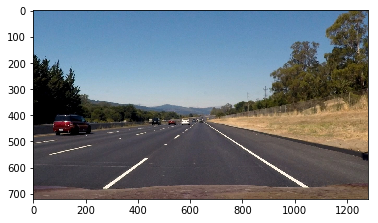

In [117]:
# Get test image
test_image = cv2.imread('./test_images/straight_lines2.jpg')
# test_image = cv2.imread('./test_images/test6.jpg')

# clip = VideoFileClip('./project_video.mp4')
# print('FPS: {}'.format(clip.fps))
# print('Duration: {}'.format(clip.duration))
# print('Frames: {}'.format(clip.fps * clip.duration))

# test_image = clip.get_frame(41.88)

rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb, cmap='gray')

(1280, 720)
MTX: [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Dist: [[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


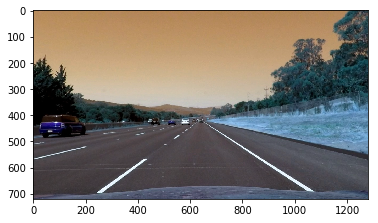

In [118]:
# Undistort image
img_size = (test_image.shape[1], test_image.shape[0])
print(img_size)
_, mtx, dist, _, _ = calibrate.calibrate_camera(obj_pts, img_pts, img_size)

print('MTX: {}'.format(mtx))
print('Dist: {}'.format(dist))
undistort = calibrate.undistort(test_image, mtx, dist)
undistort_rgb = cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB)

plt.imshow(undistort, cmap='gray')

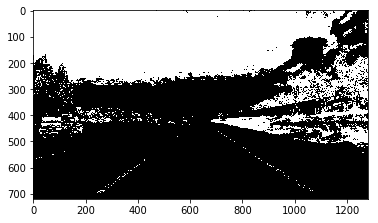

In [119]:
# Color space

hls = binary.hls_select(undistort, ch_filter=2, thresh=(90, 190))
plt.imshow(hls, cmap='gray')

In [120]:
# # Sobel (abs)

# sobel_x = sobel.abs_sobel_thresh(undistort, orient='x', thresh=(20, 255))
# sobel_y = sobel.abs_sobel_thresh(undistort, orient='y', thresh=(20, 255))

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()

# ax1.imshow(sobel_x, cmap='gray')
# ax1.set_title('Sobel X', fontsize=50)

# ax2.imshow(sobel_y, cmap='gray')
# ax2.set_title('Sobel Y', fontsize=50)

# plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

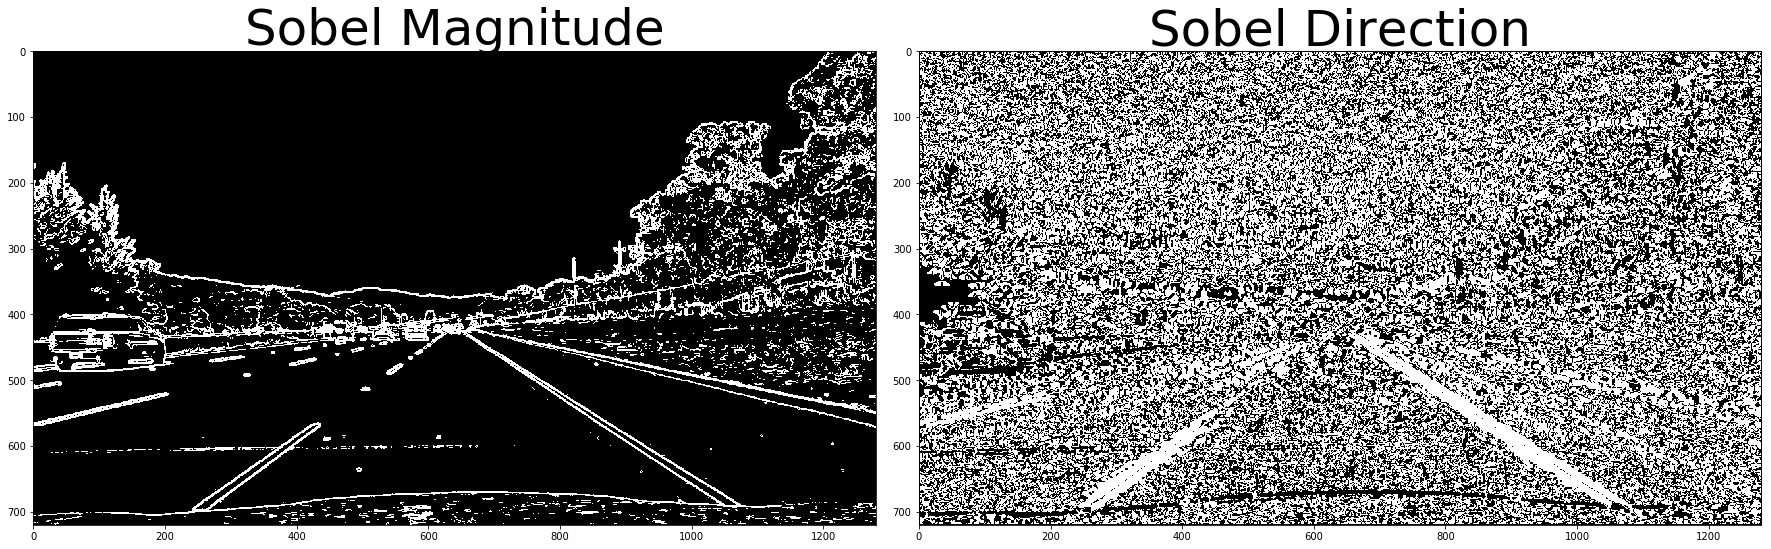

In [121]:
# Sobel dir

mag = binary.mag_thresh(undistort, thresh=(20, 255))
# direct = sobel.dir_thresh(undistort, thresh=(np.pi/4, np.pi/2))
# direct = sobel.dir_thresh(undistort, thresh=(np.pi/10, np.pi/3))
direct = binary.dir_thresh(undistort, thresh=(0.6, 1.4), kernel=15)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(mag, cmap='gray')
ax1.set_title('Sobel Magnitude', fontsize=50)

ax2.imshow(direct, cmap='gray')
ax2.set_title('Sobel Direction', fontsize=50)

plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

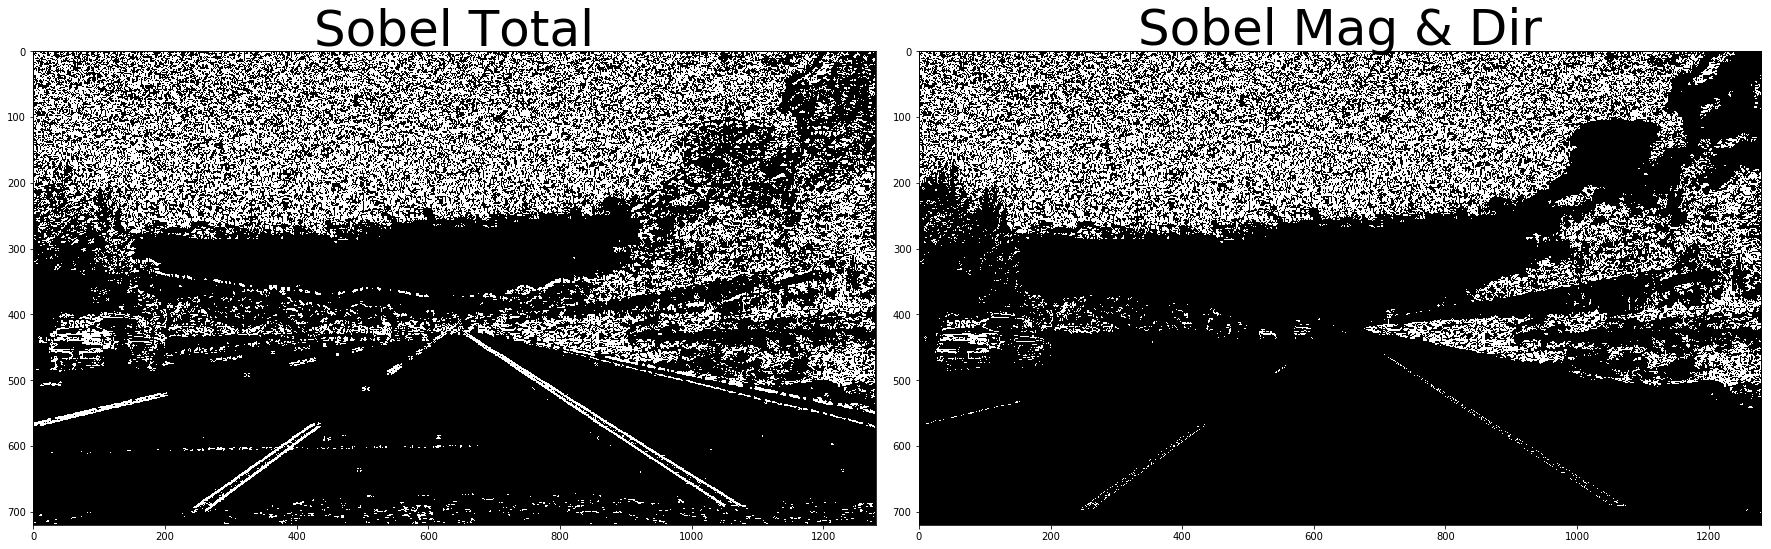

In [122]:
combined = np.zeros_like(hls)
combined_2 = np.zeros_like(hls)

combined[((hls == 1) & (direct == 1)) | 
         ((direct == 1) & (mag == 1)) | 
         ((hls == 1) & (mag == 1))] = 1
combined_2[(hls == 1) & ((direct == 1) | (mag == 1))] = 1
# combined_2[(direct == 1)] = 1

# plt.imshow(combined, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(combined, cmap='gray')
ax1.set_title('Sobel Total', fontsize=50)

ax2.imshow(combined_2, cmap='gray')
ax2.set_title('Sobel Mag & Dir', fontsize=50)

plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

(720, 1280, 3)


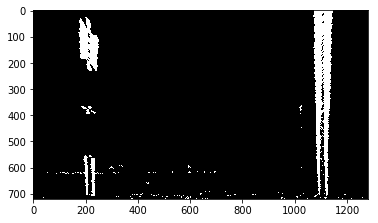

In [150]:
print(undistort.shape)

# mid point = 525
# slope = -0.65
# min_y = 425
# max_y = 720

# min_x_bot = 150
# max_x_bot = 1200

# center = (max_x_bot - min_x_bot) / 2

src = np.float32([
    (507, 500),
    (792, 500),
    (150, 720),
    (1200, 720)
])
dst = np.float32([
    (150, 300),
    (1200, 300),
    (150, 720),
    (1200, 720)
])
warped = transform.transform(combined, src, dst)
plt.imshow(warped, cmap='gray')

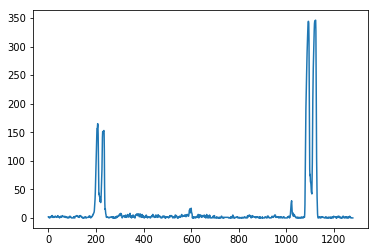

In [146]:
# Find lines with histogram
hist = histogram.histogram(warped)
plt.plot(hist)

In [151]:
# Perform search
sw = histogram.SlidingWindow(warped)
sw.search()

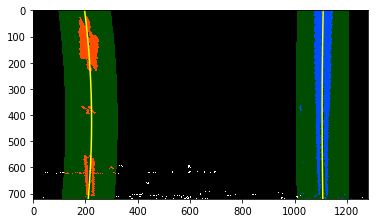

In [152]:
# Visualize search
sw.visualize()

In [153]:
sw.curvature_ft()

(562.98880727488051, 3261.6032454557785)

In [166]:
print(sw.left_x)
print(sw.right_x)

frame_center = warped.shape[1] / 2
print(frame_center)

lane_center = (sw.right_x[-1] + sw.left_x[-1]) / 2
print(lane_center)

offset = frame_center - lane_center
print(offset)

[ 197.01762095  197.08830648  197.15889836 ...,  210.98324143  210.9343348
  210.88533451]
[ 1109.09240948  1109.08103872  1109.06968411 ...,  1107.72910078
  1107.73835252  1107.7476204 ]
640.0
659.316477456
-19.3164774564


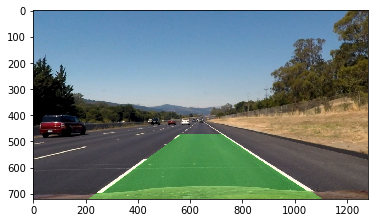

In [154]:
result = transform.unwarp_lane(
    warped, 
    orig_img=cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB),
    src=src, dst=dst,
    plot_y=sw.plot_y,
    left_x=sw.left_x, right_x=sw.right_x    
)
plt.imshow(result, cmap='gray')

------

## Appendix

In [22]:
import run

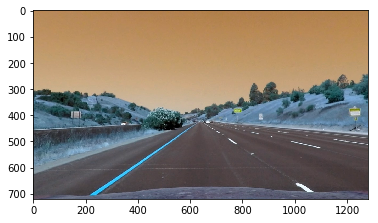

In [23]:
undistort = calibrate.undistort(test_image, mtx, dist)
plt.imshow(undistort, cmap='gray')

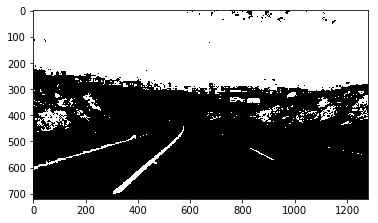

In [513]:
# binary = run.apply_filters(undistort)
# plt.imshow(binary)
hls = hls_select(undistort, thresh=(90, 255))
plt.imshow(hls, cmap='gray')

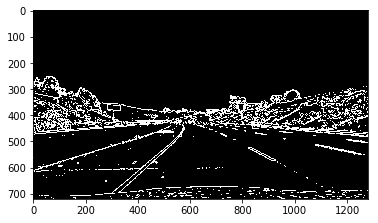

In [515]:
mag = sobel.mag_thresh(undistort, thresh=(20, 255))
plt.imshow(mag, cmap='gray')

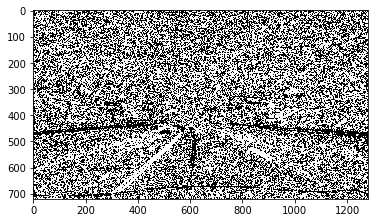

In [517]:
direction = sobel.dir_thresh(undistort, thresh=(0.6, 1.4), kernel=15)
plt.imshow(direction, cmap='gray')

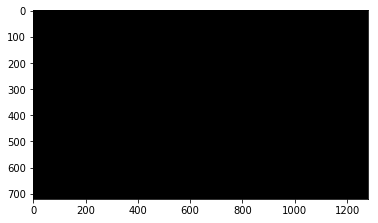

In [523]:
combined = np.zeros_like(hls)
plt.imshow(combined, cmap='gray')

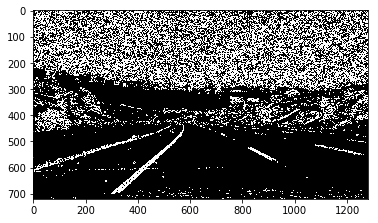

In [532]:
combined[((hls == 1) & (direction == 1)) |
         ((direction == 1) & (mag == 1)) |
         ((hls == 1) & (mag == 1))] = 1
plt.imshow(combined, cmap='gray')

In [541]:
p = run.ImageProcessor(mtx, dist, src, dst)

> Processing frame 1


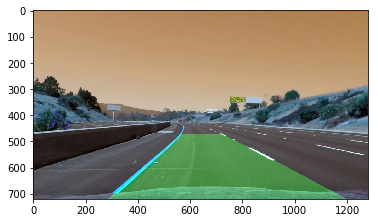

In [543]:
res = p.process_image(test_image)
plt.imshow(res)

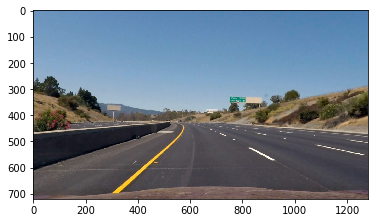

In [547]:
rgb = cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB)
plt.imshow(undistort, cmap='gray')

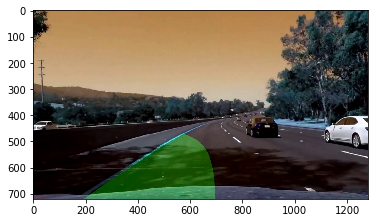

In [563]:
processed_clip = VideoFileClip('./processed_project_video.mp4')
img = processed_clip.get_frame(41.88)
plt.imshow(img)